# Ligand exploration with RDKit

Inspect the ligand stored at `$COURSE_DIR/data/complex/ligand1.sdf` with RDKit, collecting both standard and richer descriptors plus 2D and 3D renderings before the OpenMM workflow.


## Table of contents

- [Step 1](#step-1)
- [Step 2](#step-2)
- [Step 3](#step-3)
- [Step 4](#step-4)
- [Step 5](#step-5)
- [Step 6](#step-6)
- [Step 7](#step-7)


## Step 1


The ligand originates in the shared `COURSE_DIR/data/complex/ligand1.sdf` path, so we sanitize it, compute physicochemical descriptors, and then synthesize visualizations (2D sketch, py3Dmol 3D model, nglview widget) to ensure the molecule is fully inspected.


In [21]:
from pathlib import Path
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, rdMolDescriptors, rdPartialCharges
from rdkit.Chem.Draw import MolsToImage
from IPython.display import display
import pandas as pd
import py3Dmol

COURSE_DIR = Path(os.environ.get("COURSE_DIR", str(Path.home() / "Concepcion26"))).expanduser()
LIGAND_SDF = COURSE_DIR / "data" / "complex" / "ligand1.sdf"

if not LIGAND_SDF.exists():
    raise FileNotFoundError(f"Missing ligand file: {LIGAND_SDF}")

supplier = Chem.SDMolSupplier(str(LIGAND_SDF), removeHs=False)
mols = [mol for mol in supplier if mol is not None]
if not mols:
    raise ValueError("The ligand file did not yield any RDKit molecules.")
for mol in mols:
    Chem.SanitizeMol(mol)

print(f"Loaded {len(mols)} sanitized molecule(s) from {LIGAND_SDF}")
model = Chem.AddHs(mols[0])
AllChem.EmbedMolecule(model, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(model)

Loaded 1 sanitized molecule(s) from /home/jordivilla/Concepcion26/data/complex/ligand1.sdf


0

## Step 2


In [22]:
descriptor_functions = {
    "exact_mass": Descriptors.ExactMolWt,
    "heavy_atom_count": Descriptors.HeavyAtomCount,
    "mol_mr": Descriptors.MolMR,
    "valence_electrons": Descriptors.NumValenceElectrons,
    "ring_count": rdMolDescriptors.CalcNumRings,
    "aromatic_ring_count": rdMolDescriptors.CalcNumAromaticRings,
    "heteroatom_count": rdMolDescriptors.CalcNumHeteroatoms,
    "fraction_csp3": rdMolDescriptors.CalcFractionCSP3,
    "stereo_centers": rdMolDescriptors.CalcNumAtomStereoCenters,
    "chi0n": rdMolDescriptors.CalcChi0n,
    "labute_asa": rdMolDescriptors.CalcLabuteASA,
}
records = []
for idx, mol in enumerate(mols, start=1):
    smiles = Chem.MolToSmiles(mol)
    temp = Chem.AddHs(mol)
    rdPartialCharges.ComputeGasteigerCharges(temp, nIter=12)
    charges = [float(atom.GetProp("_GasteigerCharge")) for atom in temp.GetAtoms() if atom.HasProp("_GasteigerCharge")]
    record = {
        "index": idx,
        "smiles": smiles,
        "formula": rdMolDescriptors.CalcMolFormula(mol),
        "mw": Descriptors.MolWt(mol),
        "tpsa": rdMolDescriptors.CalcTPSA(mol),
        "logp": Descriptors.MolLogP(mol),
        "hbd": rdMolDescriptors.CalcNumHBD(mol),
        "hba": rdMolDescriptors.CalcNumHBA(mol),
        "rotatable_bonds": Descriptors.NumRotatableBonds(mol),
        "gasteiger_max": max(charges) if charges else None,
        "gasteiger_min": min(charges) if charges else None,
    }
    for name, func in descriptor_functions.items():
        try:
            record[name] = func(mol)
        except Exception:
            record[name] = None
    records.append(record)
df = pd.DataFrame(records).set_index("index")
df

,smiles,formula,mw,tpsa,logp,hbd,hba,rotatable_bonds,gasteiger_max,gasteiger_min,...,heavy_atom_count,mol_mr,valence_electrons,ring_count,aromatic_ring_count,heteroatom_count,fraction_csp3,stereo_centers,chi0n,labute_asa
index,,,,,,,,,,,,,,,,,,,,,
1,[H]c1c([H])c([H])c(C(=O)OC([H])([H])C([H])([H]...,C9H10O2,150.177,26.3,1.8633,0,2,3,0.337607,-0.462391,...,11,42.3985,58,1,1,2,0.222222,0,15.316497,79.851002


## Step 3


RDKit produces a 2D sketch for quick inspection.


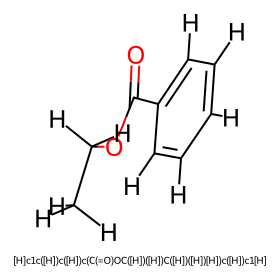

In [23]:
print("RDKit produces a 2D sketch for quick inspection.")
display(MolsToImage(mols, legends=[record["smiles"] for record in records], subImgSize=(280, 280)))

## Step 4


In [24]:
print("Prepare an embedded 3D model for py3Dmol rendering.")
mol_block = Chem.MolToMolBlock(model)
view = py3Dmol.view(width=400, height=320)
view.addModel(mol_block, "sdf")
view.setStyle({"stick": {}})
view.setBackgroundColor("0xeeeeee")
view.zoomTo()
display(view)

Prepare an embedded 3D model for py3Dmol rendering.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 5


In [25]:
import nglview as nv
from rdkit.Chem import MolToPDBBlock

pdb_block = MolToPDBBlock(model)
view = nv.NGLWidget()
view.add_component(nv.TextStructure(pdb_block))
view.clear_representations()
view.add_representation("ball+stick")
view.center()
view

NGLWidget()

## Step 6


In [26]:
import requests
from urllib.parse import quote

smiles = Chem.MolToSmiles(mols[0])
print('PubChem search for', smiles)
encoded = quote(smiles, safe='')
cid = None
try:
    resp = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{encoded}/cids/JSON', timeout=15)
    resp.raise_for_status()
    cids = resp.json().get('IdentifierList', {}).get('CID', [])
    cid = cids[0] if cids else None
except requests.RequestException as exc:
    print('PubChem CID lookup failed:', exc)

if cid is None:
    print('No PubChem CID found for the smiles string.')
else:
    globals()['PUBCHEM_CID'] = cid
    print('PubChem CID:', cid)
    try:
        info = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/description/JSON', timeout=15)
        info.raise_for_status()
        descriptions = info.json().get('InformationList', {}).get('Information', [])
        description = descriptions[0].get('Description') if descriptions else None
    except requests.RequestException as exc:
        print('Description fetch failed:', exc)
        description = None
    prop_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularFormula,MolecularWeight,IUPACName,CanonicalSMILES,InChIKey/JSON'
    properties = None
    try:
        prop_resp = requests.get(prop_url, timeout=15)
        prop_resp.raise_for_status()
        properties = prop_resp.json().get('PropertyTable', {}).get('Properties', [])
        properties = properties[0] if properties else None
    except requests.RequestException as exc:
        print('Property fetch failed:', exc)
    synonyms = []
    try:
        syn_resp = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/synonyms/JSON', timeout=15)
        syn_resp.raise_for_status()
        synonym_list = syn_resp.json().get('InformationList', {}).get('Information', [])
        synonyms = synonym_list[0].get('Synonym', []) if synonym_list else []
    except requests.RequestException as exc:
        print('Synonym fetch failed:', exc)
    print('Description:', description or '<none>')
    if properties:
        print('Properties:', {k: properties.get(k) for k in ('MolecularFormula','MolecularWeight','IUPACName','CanonicalSMILES','InChIKey')})
    if synonyms:
        print('Synonyms (top 5):', synonyms[:5])

PubChem search for [H]c1c([H])c([H])c(C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H]
PubChem CID: 7165
Description: <none>
Properties: {'MolecularFormula': 'C9H10O2', 'MolecularWeight': '150.17', 'IUPACName': 'ethyl benzoate', 'CanonicalSMILES': None, 'InChIKey': 'MTZQAGJQAFMTAQ-UHFFFAOYSA-N'}
Synonyms (top 5): ['ETHYL BENZOATE', '93-89-0', 'Benzoic ether', 'Ethyl benzenecarboxylate', 'Benzoic Acid Ethyl Ester']


## Step 7


In [27]:
import requests
from urllib.parse import quote_plus

query = Chem.MolToSmiles(mols[0])
print('DrugBank search query (SMILES):', query)
params = {'searcher': 'drugs', 'q': query, 'format': 'json'}
url = 'https://go.drugbank.com/unearth/q'
hits = []
try:
    resp = requests.get(url, params=params, timeout=15)
    resp.raise_for_status()
    payload = resp.json()
    hits = payload.get('hits') or payload.get('documents') or []
except requests.RequestException as exc:
    print('DrugBank search failed:', exc)
if not hits:
    print('No structured DrugBank hits available from the query.')
else:
    top = hits[0]
    def pick(*keys):
        for key in keys:
            value = top.get(key)
            if value:
                return value
        return None
    name = pick('name', 'drugbank_id', 'title')
    description = pick('description', 'summary', 'synopsis')
    status = pick('drugbank_type', 'group', 'drug_type')
    print('DrugBank top hit:', name or '<unknown>')
    print('Description/summary:', description or '<none>')
    print('Group/status:', status or '<not provided>')
    for extras in ('indication', 'mechanism_of_action', 'molecular_weight'):
        value = pick(extras)
        if value:
            print(f"{extras.replace('_',' ').title()}:", value)

DrugBank search query (SMILES): [H]c1c([H])c([H])c(C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H]
DrugBank search failed: 403 Client Error: Forbidden for url: https://go.drugbank.com/unearth/q?searcher=drugs&q=%5BH%5Dc1c%28%5BH%5D%29c%28%5BH%5D%29c%28C%28%3DO%29OC%28%5BH%5D%29%28%5BH%5D%29C%28%5BH%5D%29%28%5BH%5D%29%5BH%5D%29c%28%5BH%5D%29c1%5BH%5D&format=json
No structured DrugBank hits available from the query.
